In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, Dataset
from itertools import product

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Kathmandu-Precipitation/data/Outlier-removed-dataset.csv")
features = [ i for i in df.columns if i not in ["precipitation","datetime"]]
target = ["precipitation"]
X = df[features]
y = df[target]

In [3]:
X

,tempmax,tempmin,humidity,sealevelpressure,cloudcover,season_sin,season_cos
0,75.1,51.7,69.1,1014.5,40.1,0.95,0.31
1,75.1,55.3,65.2,1011.5,49.2,0.95,0.31
2,76.9,55.3,69.7,1010.6,41.3,0.95,0.31
3,78.7,51.7,74.2,1011.3,50.5,0.95,0.31
4,75.1,49.9,66.9,1013.0,43.8,0.95,0.31
...,...,...,...,...,...,...,...
1506,82.3,69.7,86.1,1010.5,81.7,-0.59,-0.81
1507,84.1,71.5,85.9,1011.7,75.9,-0.59,-0.81
1508,82.3,69.7,84.0,1010.3,80.1,-0.59,-0.81
1509,82.3,71.5,84.3,1009.3,86.4,-0.59,-0.81


In [ ]:
scaler_features = StandardScaler()
scaler_target = StandardScaler()
features_scaled = scaler_features.fit_transform(X)
target_scaled = scaler_target.fit_transform(y).flatten()

In [ ]:
# Create sequences for LSTM
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Number of time steps in each sequence
X, y = create_sequences(features_scaled, target_scaled, seq_length)

In [ ]:
# Split into training, validation, and testing sets (rolling window)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=True):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Hyperparameter grid
param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'bidirectional': [True, False]  # Include unidirectional LSTM for comparison
}

best_rmse = float('inf')
best_params = None

for params in product(*param_grid.values()):
    hidden_size, num_layers, learning_rate, batch_size, bidirectional = params

    # Instantiate the model
    model = BiLSTMModel(
        input_size=7,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=1,
        bidirectional=bidirectional
    )
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 20
    train_data = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val).squeeze().numpy()
        val_predictions_rescaled = scaler_target.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
        y_val_rescaled = scaler_target.inverse_transform(y_val.numpy().reshape(-1, 1)).flatten()

        val_rmse = np.sqrt(mean_squared_error(y_val_rescaled, val_predictions_rescaled))

    print(f"Params: {params}, Validation RMSE: {val_rmse:.4f}")

    # Save best parameters
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_params = params

print(f"Best Params: {best_params}, Best Validation RMSE: {best_rmse:.4f}")

Params: (32, 1, 0.001, 16, True), Validation RMSE: 4.7871
Params: (32, 1, 0.001, 16, False), Validation RMSE: 4.7969
Params: (32, 1, 0.001, 32, True), Validation RMSE: 4.7937
Params: (32, 1, 0.001, 32, False), Validation RMSE: 4.7825
Params: (32, 1, 0.01, 16, True), Validation RMSE: 4.9226
Params: (32, 1, 0.01, 16, False), Validation RMSE: 4.8699
Params: (32, 1, 0.01, 32, True), Validation RMSE: 5.2938
Params: (32, 1, 0.01, 32, False), Validation RMSE: 5.3279
Params: (32, 2, 0.001, 16, True), Validation RMSE: 4.8608
Params: (32, 2, 0.001, 16, False), Validation RMSE: 4.8367
Params: (32, 2, 0.001, 32, True), Validation RMSE: 4.7518
Params: (32, 2, 0.001, 32, False), Validation RMSE: 4.8205
Params: (32, 2, 0.01, 16, True), Validation RMSE: 4.9666
Params: (32, 2, 0.01, 16, False), Validation RMSE: 4.8280
Params: (32, 2, 0.01, 32, True), Validation RMSE: 5.0366
Params: (32, 2, 0.01, 32, False), Validation RMSE: 5.7878
Params: (64, 1, 0.001, 16, True), Validation RMSE: 5.0389
Params: (64, 1

In [ ]:
# Retrain with best parameters
hidden_size, num_layers, learning_rate, batch_size, bidirectional = best_params
model = BiLSTMModel(
    input_size=7,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=1,
    bidirectional=bidirectional
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Combine training and validation sets
X_train_full = torch.cat((X_train, X_val), dim=0)
y_train_full = torch.cat((y_train, y_val), dim=0)
train_data = torch.utils.data.TensorDataset(X_train_full, y_train_full)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

# Train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}")

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test).squeeze().numpy()
    test_predictions_rescaled = scaler_target.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
    y_test_rescaled = scaler_target.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()

    test_mse = mean_squared_error(y_test_rescaled, test_predictions_rescaled)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)

print(f"Test Metrics:")
print(f"  Test MSE: {test_mse:.4f}")
print(f"  Test RMSE: {test_rmse:.4f}")
print(f"  Test MAE: {test_mae:.4f}")

Epoch [1/20], Training Loss: 1.0086
Epoch [2/20], Training Loss: 0.9460
Epoch [3/20], Training Loss: 0.9363
Epoch [4/20], Training Loss: 0.9210
Epoch [5/20], Training Loss: 0.9163
Epoch [6/20], Training Loss: 0.9110
Epoch [7/20], Training Loss: 0.9061
Epoch [8/20], Training Loss: 0.8988
Epoch [9/20], Training Loss: 0.8954
Epoch [10/20], Training Loss: 0.8968
Epoch [11/20], Training Loss: 0.8889
Epoch [12/20], Training Loss: 0.8946
Epoch [13/20], Training Loss: 0.8761
Epoch [14/20], Training Loss: 0.8762
Epoch [15/20], Training Loss: 0.8673
Epoch [16/20], Training Loss: 0.8540
Epoch [17/20], Training Loss: 0.9059
Epoch [18/20], Training Loss: 0.8732
Epoch [19/20], Training Loss: 0.8733
Epoch [20/20], Training Loss: 0.8611
Test Metrics:
  Test MSE: 14.3575
  Test RMSE: 3.7891
  Test MAE: 2.6464


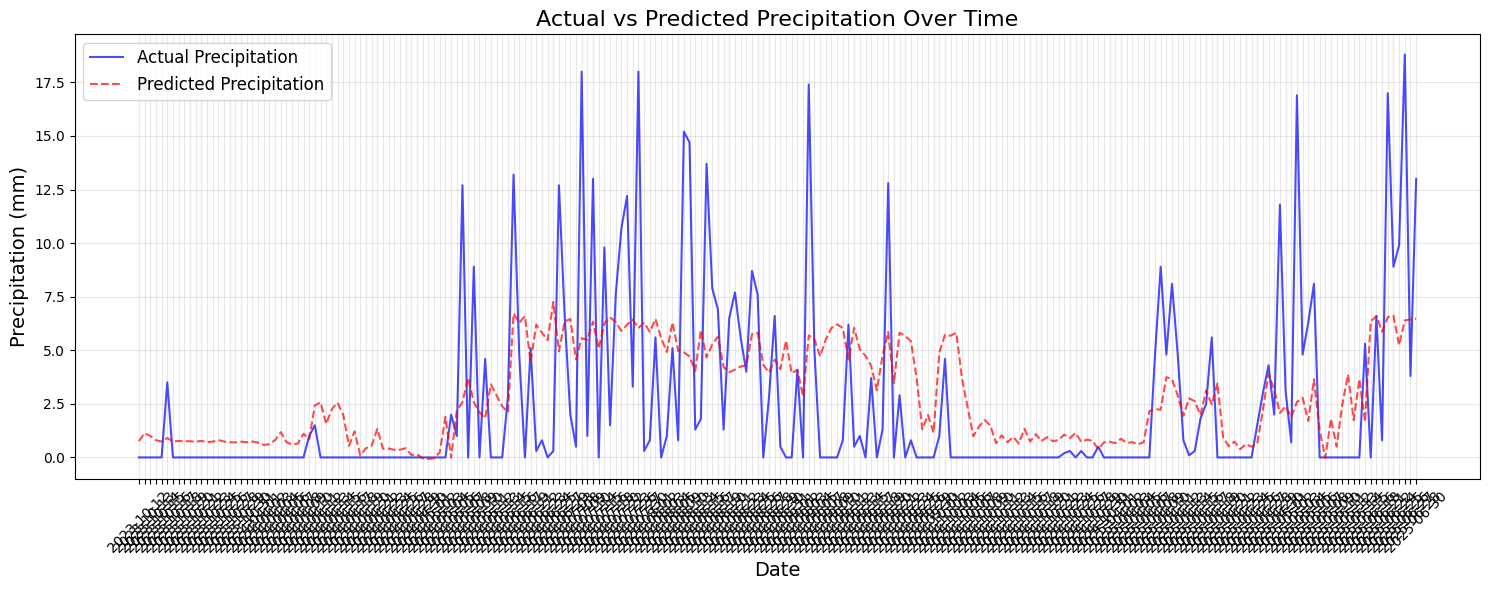

In [ ]:
import matplotlib.pyplot as plt

# After your test evaluation code, add:

# Create a time index for plotting (using the original datetime column)
test_dates = df['datetime'].iloc[train_size+val_size+seq_length:train_size+val_size+seq_length+len(y_test_rescaled)]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_rescaled, label='Actual Precipitation', color='blue', alpha=0.7)
plt.plot(test_dates, test_predictions_rescaled, label='Predicted Precipitation', color='red', alpha=0.7, linestyle='--')

# Formatting
plt.title('Actual vs Predicted Precipitation Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Precipitation (mm)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

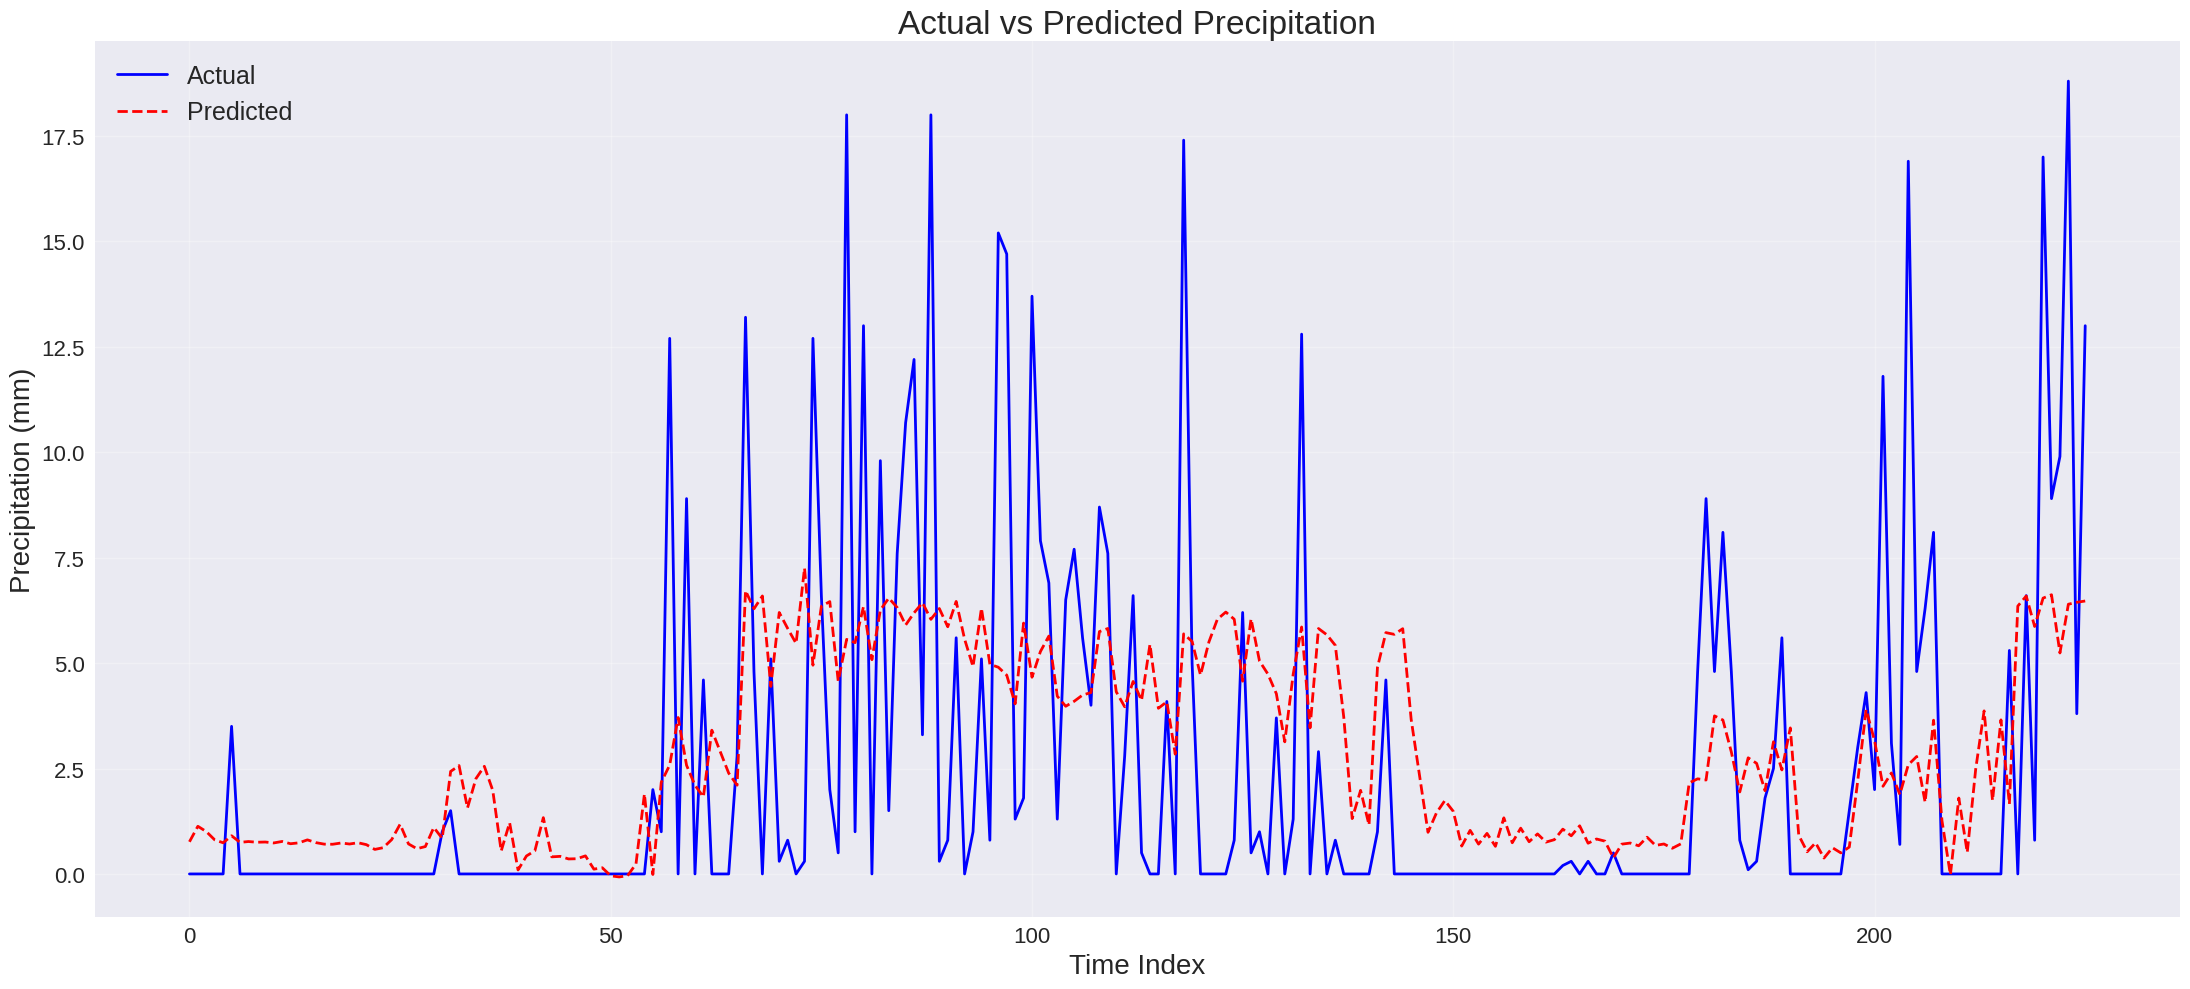

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 10))  # Wider and larger figure

# Plot predictions vs actual in a single plot
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual', color='blue', linewidth=2)
plt.plot(range(len(test_predictions_rescaled)), test_predictions_rescaled,
         label='Predicted', color='red', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted Precipitation', fontsize=24)
plt.xlabel('Time Index', fontsize=20)
plt.ylabel('Precipitation (mm)', fontsize=20)
plt.legend(fontsize=18)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig("precip_plot_tight.png", bbox_inches='tight')  # Saves cropped
plt.show()
plt.close()


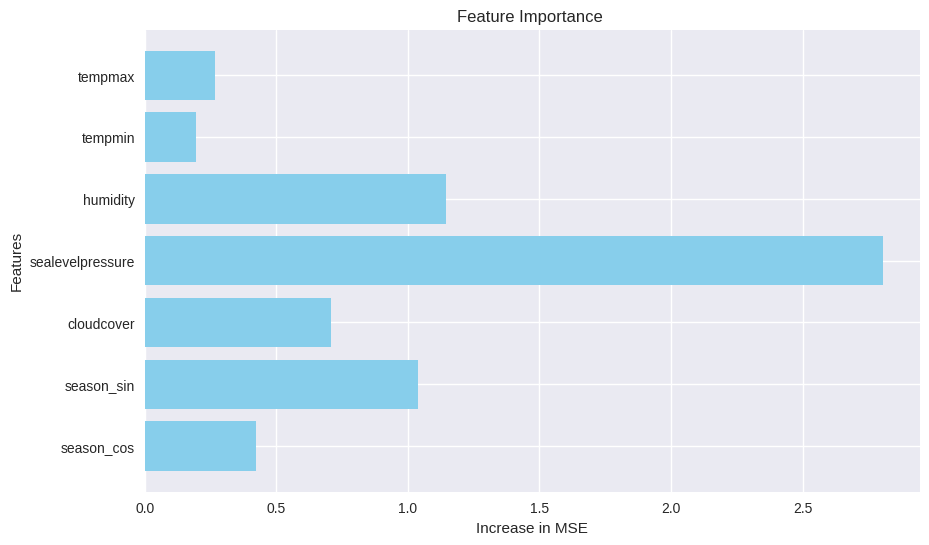

In [ ]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X, y, scaler_target, num_permutations=10):
    """
    Compute permutation importance for each feature.

    Args:
        model: Trained PyTorch model.
        X: Input data (torch tensor).
        y: Target data (torch tensor).
        scaler_target: Scaler used for inverse transformation of predictions.
        num_permutations: Number of times to shuffle each feature.

    Returns:
        feature_importance: List of importance scores for each feature.
    """
    model.eval()
    baseline_predictions = model(X).squeeze().detach().numpy()
    baseline_predictions_rescaled = scaler_target.inverse_transform(baseline_predictions.reshape(-1, 1)).flatten()
    baseline_mse = mean_squared_error(scaler_target.inverse_transform(y.numpy().reshape(-1, 1)).flatten(), baseline_predictions_rescaled)

    feature_importance = []

    for feature_idx in range(X.shape[2]):  # Iterate over each feature
        mse_increase = []

        for _ in range(num_permutations):
            X_permuted = X.clone()  # Create a copy of the input data
            X_permuted[:, :, feature_idx] = X[:, :, feature_idx][torch.randperm(X.shape[0])]  # Shuffle the feature

            permuted_predictions = model(X_permuted).squeeze().detach().numpy()
            permuted_predictions_rescaled = scaler_target.inverse_transform(permuted_predictions.reshape(-1, 1)).flatten()

            permuted_mse = mean_squared_error(scaler_target.inverse_transform(y.numpy().reshape(-1, 1)).flatten(), permuted_predictions_rescaled)
            mse_increase.append(permuted_mse - baseline_mse)

        feature_importance.append(np.mean(mse_increase))

    return feature_importance

# Compute feature importance
feature_importance = permutation_importance(model, X_test, y_test, scaler_target)

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Increase in MSE")
plt.ylabel("Features")
plt.title("Feature Importance ")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()